# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

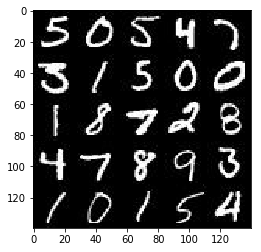

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CE||LL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

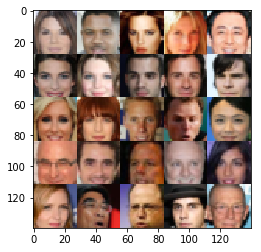

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)
    return images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 4, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.maximum(0.2 * x, x)
        x = tf.layers.conv2d(x, 128, 4, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.dropout(x, 0.5)
        x = tf.maximum(0.2 * x, x)
        x = tf.reshape(x, (-1, 7 * 7 * 128))
        x = tf.layers.dense(x, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
    return tf.sigmoid(x), x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7 * 7 * 512,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.maximum(0.2 * x, x)
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.dropout(x, 0.5)
        x = tf.maximum(0.2 * x, x)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    return tf.tanh(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    n_batches = data_shape[0] // batch_size + (data_shape[0] % batch_size != 0)
    counter = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                counter += 1
                feed = {
                    # get_batches has already rescaled between -0.5 and 0.5
                    # now rescale between -1 and 1 by subtracting back -0.5,
                    # multiplying by 1 - (-1) and adding -1
                    input_real: (batch_images + 0.5) * 2 - 1,
                    input_z: np.random.uniform(-1, 1, (batch_size, z_dim)),
                    lr: learning_rate
                }
                sess.run(d_opt, feed_dict=feed)
                sess.run(g_opt, feed_dict=feed)
                if counter % (n_batches // 64) == 0:
                    print('Epoch {}/{}'.format(epoch_i + 1, epoch_count),
                          'Batch {}/{}'.format(counter, n_batches),
                          'Discriminator loss {:.4}'.format(sess.run(d_loss, feed_dict=feed)),
                          'Generator loss {:.4}'.format(sess.run(g_loss, feed_dict=feed)))
                if counter % (n_batches // 8) == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                if counter >= n_batches:
                    counter = 0
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch 117/7500 Discriminator loss 1.316 Generator loss 1.099
Epoch 1/2 Batch 234/7500 Discriminator loss 0.901 Generator loss 2.132
Epoch 1/2 Batch 351/7500 Discriminator loss 0.5093 Generator loss 2.266
Epoch 1/2 Batch 468/7500 Discriminator loss 0.4116 Generator loss 3.833
Epoch 1/2 Batch 585/7500 Discriminator loss 0.7403 Generator loss 3.076
Epoch 1/2 Batch 702/7500 Discriminator loss 1.021 Generator loss 1.879
Epoch 1/2 Batch 819/7500 Discriminator loss 0.7807 Generator loss 2.604
Epoch 1/2 Batch 936/7500 Discriminator loss 0.6187 Generator loss 1.806


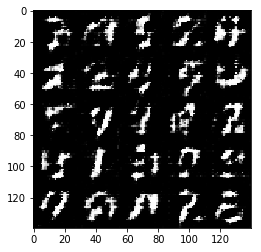

Epoch 1/2 Batch 1053/7500 Discriminator loss 0.9763 Generator loss 1.705
Epoch 1/2 Batch 1170/7500 Discriminator loss 1.444 Generator loss 1.04
Epoch 1/2 Batch 1287/7500 Discriminator loss 0.6936 Generator loss 1.877
Epoch 1/2 Batch 1404/7500 Discriminator loss 0.8435 Generator loss 2.274
Epoch 1/2 Batch 1521/7500 Discriminator loss 2.107 Generator loss 0.3606
Epoch 1/2 Batch 1638/7500 Discriminator loss 1.115 Generator loss 1.577
Epoch 1/2 Batch 1755/7500 Discriminator loss 0.7092 Generator loss 2.02
Epoch 1/2 Batch 1872/7500 Discriminator loss 1.185 Generator loss 0.8106


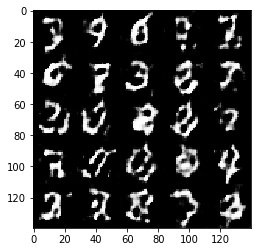

Epoch 1/2 Batch 1989/7500 Discriminator loss 1.19 Generator loss 1.29
Epoch 1/2 Batch 2106/7500 Discriminator loss 0.7033 Generator loss 1.658
Epoch 1/2 Batch 2223/7500 Discriminator loss 0.7564 Generator loss 1.879
Epoch 1/2 Batch 2340/7500 Discriminator loss 1.286 Generator loss 1.937
Epoch 1/2 Batch 2457/7500 Discriminator loss 0.9366 Generator loss 1.385
Epoch 1/2 Batch 2574/7500 Discriminator loss 1.197 Generator loss 1.503
Epoch 1/2 Batch 2691/7500 Discriminator loss 0.6692 Generator loss 2.411
Epoch 1/2 Batch 2808/7500 Discriminator loss 0.8468 Generator loss 1.17


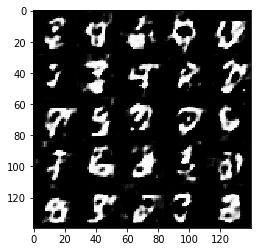

Epoch 1/2 Batch 2925/7500 Discriminator loss 1.411 Generator loss 1.44
Epoch 1/2 Batch 3042/7500 Discriminator loss 1.498 Generator loss 1.562
Epoch 1/2 Batch 3159/7500 Discriminator loss 0.8866 Generator loss 1.71
Epoch 1/2 Batch 3276/7500 Discriminator loss 1.05 Generator loss 1.888
Epoch 1/2 Batch 3393/7500 Discriminator loss 1.281 Generator loss 1.914
Epoch 1/2 Batch 3510/7500 Discriminator loss 1.101 Generator loss 1.464
Epoch 1/2 Batch 3627/7500 Discriminator loss 0.9809 Generator loss 1.569
Epoch 1/2 Batch 3744/7500 Discriminator loss 1.999 Generator loss 1.122


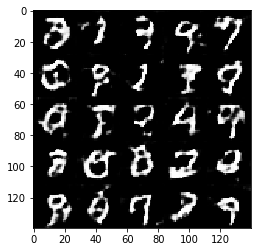

Epoch 1/2 Batch 3861/7500 Discriminator loss 1.195 Generator loss 0.7567
Epoch 1/2 Batch 3978/7500 Discriminator loss 1.084 Generator loss 1.449
Epoch 1/2 Batch 4095/7500 Discriminator loss 1.937 Generator loss 1.613
Epoch 1/2 Batch 4212/7500 Discriminator loss 1.08 Generator loss 2.032
Epoch 1/2 Batch 4329/7500 Discriminator loss 1.332 Generator loss 0.7915
Epoch 1/2 Batch 4446/7500 Discriminator loss 0.7921 Generator loss 0.9556
Epoch 1/2 Batch 4563/7500 Discriminator loss 1.131 Generator loss 1.61
Epoch 1/2 Batch 4680/7500 Discriminator loss 1.14 Generator loss 1.569


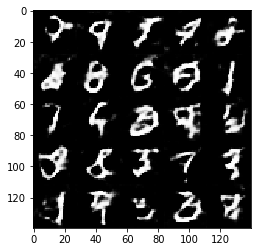

Epoch 1/2 Batch 4797/7500 Discriminator loss 0.9497 Generator loss 1.234
Epoch 1/2 Batch 4914/7500 Discriminator loss 1.311 Generator loss 2.137
Epoch 1/2 Batch 5031/7500 Discriminator loss 0.7742 Generator loss 1.062
Epoch 1/2 Batch 5148/7500 Discriminator loss 1.041 Generator loss 1.079
Epoch 1/2 Batch 5265/7500 Discriminator loss 0.9529 Generator loss 1.635
Epoch 1/2 Batch 5382/7500 Discriminator loss 1.199 Generator loss 0.8971
Epoch 1/2 Batch 5499/7500 Discriminator loss 0.7336 Generator loss 1.839
Epoch 1/2 Batch 5616/7500 Discriminator loss 1.189 Generator loss 1.444


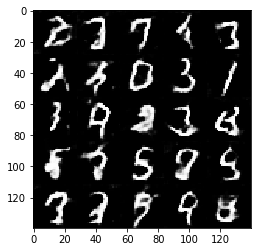

Epoch 1/2 Batch 5733/7500 Discriminator loss 0.9929 Generator loss 1.018
Epoch 1/2 Batch 5850/7500 Discriminator loss 1.552 Generator loss 1.67
Epoch 1/2 Batch 5967/7500 Discriminator loss 0.7754 Generator loss 1.694
Epoch 1/2 Batch 6084/7500 Discriminator loss 0.6588 Generator loss 2.013
Epoch 1/2 Batch 6201/7500 Discriminator loss 1.0 Generator loss 1.31
Epoch 1/2 Batch 6318/7500 Discriminator loss 1.66 Generator loss 1.878
Epoch 1/2 Batch 6435/7500 Discriminator loss 1.318 Generator loss 1.434
Epoch 1/2 Batch 6552/7500 Discriminator loss 0.9261 Generator loss 1.132


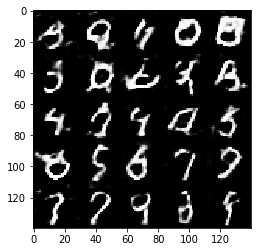

Epoch 1/2 Batch 6669/7500 Discriminator loss 0.6221 Generator loss 2.485
Epoch 1/2 Batch 6786/7500 Discriminator loss 0.9742 Generator loss 2.925
Epoch 1/2 Batch 6903/7500 Discriminator loss 0.8204 Generator loss 1.937
Epoch 1/2 Batch 7020/7500 Discriminator loss 0.699 Generator loss 2.263
Epoch 1/2 Batch 7137/7500 Discriminator loss 1.154 Generator loss 1.908
Epoch 1/2 Batch 7254/7500 Discriminator loss 1.175 Generator loss 1.517
Epoch 1/2 Batch 7371/7500 Discriminator loss 1.01 Generator loss 1.544
Epoch 1/2 Batch 7488/7500 Discriminator loss 1.099 Generator loss 1.288


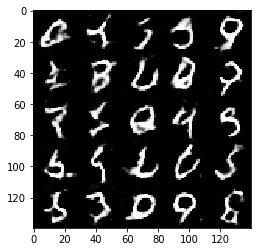

Epoch 2/2 Batch 117/7500 Discriminator loss 1.446 Generator loss 1.719
Epoch 2/2 Batch 234/7500 Discriminator loss 0.9275 Generator loss 1.832
Epoch 2/2 Batch 351/7500 Discriminator loss 0.7149 Generator loss 1.135
Epoch 2/2 Batch 468/7500 Discriminator loss 0.7971 Generator loss 1.488
Epoch 2/2 Batch 585/7500 Discriminator loss 0.905 Generator loss 1.136
Epoch 2/2 Batch 702/7500 Discriminator loss 0.9385 Generator loss 2.262
Epoch 2/2 Batch 819/7500 Discriminator loss 0.896 Generator loss 1.698
Epoch 2/2 Batch 936/7500 Discriminator loss 1.27 Generator loss 0.7971


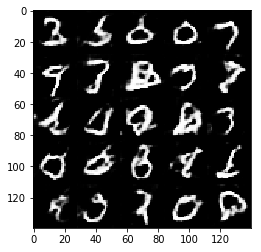

Epoch 2/2 Batch 1053/7500 Discriminator loss 1.224 Generator loss 1.179
Epoch 2/2 Batch 1170/7500 Discriminator loss 0.7538 Generator loss 1.922
Epoch 2/2 Batch 1287/7500 Discriminator loss 0.7845 Generator loss 1.927
Epoch 2/2 Batch 1404/7500 Discriminator loss 0.7445 Generator loss 1.311
Epoch 2/2 Batch 1521/7500 Discriminator loss 0.7498 Generator loss 1.813
Epoch 2/2 Batch 1638/7500 Discriminator loss 0.8975 Generator loss 1.178
Epoch 2/2 Batch 1755/7500 Discriminator loss 0.8531 Generator loss 3.067
Epoch 2/2 Batch 1872/7500 Discriminator loss 0.9004 Generator loss 2.614


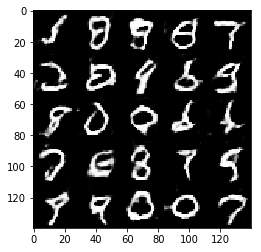

Epoch 2/2 Batch 1989/7500 Discriminator loss 1.01 Generator loss 1.894
Epoch 2/2 Batch 2106/7500 Discriminator loss 0.8107 Generator loss 1.591
Epoch 2/2 Batch 2223/7500 Discriminator loss 0.8597 Generator loss 2.411
Epoch 2/2 Batch 2340/7500 Discriminator loss 0.8692 Generator loss 1.391
Epoch 2/2 Batch 2457/7500 Discriminator loss 0.706 Generator loss 2.172
Epoch 2/2 Batch 2574/7500 Discriminator loss 0.6351 Generator loss 1.879
Epoch 2/2 Batch 2691/7500 Discriminator loss 0.7554 Generator loss 2.029
Epoch 2/2 Batch 2808/7500 Discriminator loss 0.5071 Generator loss 2.32


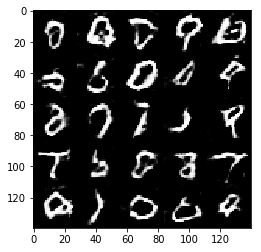

Epoch 2/2 Batch 2925/7500 Discriminator loss 0.7134 Generator loss 1.93
Epoch 2/2 Batch 3042/7500 Discriminator loss 0.9777 Generator loss 2.198
Epoch 2/2 Batch 3159/7500 Discriminator loss 0.8939 Generator loss 2.736
Epoch 2/2 Batch 3276/7500 Discriminator loss 0.5876 Generator loss 2.297
Epoch 2/2 Batch 3393/7500 Discriminator loss 0.9747 Generator loss 2.832
Epoch 2/2 Batch 3510/7500 Discriminator loss 0.6299 Generator loss 1.545
Epoch 2/2 Batch 3627/7500 Discriminator loss 0.4175 Generator loss 3.304
Epoch 2/2 Batch 3744/7500 Discriminator loss 0.9689 Generator loss 1.316


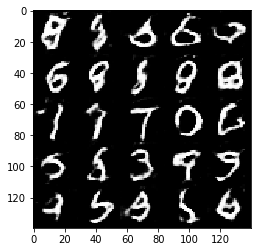

Epoch 2/2 Batch 3861/7500 Discriminator loss 0.7191 Generator loss 1.938
Epoch 2/2 Batch 3978/7500 Discriminator loss 0.6869 Generator loss 1.747
Epoch 2/2 Batch 4095/7500 Discriminator loss 1.145 Generator loss 1.951
Epoch 2/2 Batch 4212/7500 Discriminator loss 0.7118 Generator loss 2.366
Epoch 2/2 Batch 4329/7500 Discriminator loss 0.8612 Generator loss 1.596
Epoch 2/2 Batch 4446/7500 Discriminator loss 0.4609 Generator loss 2.389
Epoch 2/2 Batch 4563/7500 Discriminator loss 0.8396 Generator loss 2.408
Epoch 2/2 Batch 4680/7500 Discriminator loss 1.071 Generator loss 3.736


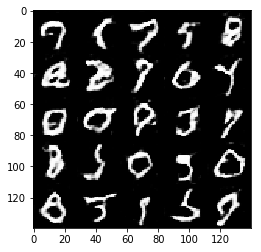

Epoch 2/2 Batch 4797/7500 Discriminator loss 0.7539 Generator loss 2.069
Epoch 2/2 Batch 4914/7500 Discriminator loss 0.5494 Generator loss 2.121
Epoch 2/2 Batch 5031/7500 Discriminator loss 0.5339 Generator loss 3.301
Epoch 2/2 Batch 5148/7500 Discriminator loss 0.6039 Generator loss 1.573
Epoch 2/2 Batch 5265/7500 Discriminator loss 0.6823 Generator loss 3.09
Epoch 2/2 Batch 5382/7500 Discriminator loss 0.656 Generator loss 2.661
Epoch 2/2 Batch 5499/7500 Discriminator loss 0.4433 Generator loss 3.821
Epoch 2/2 Batch 5616/7500 Discriminator loss 1.46 Generator loss 2.854


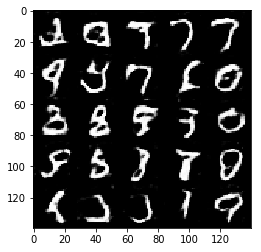

Epoch 2/2 Batch 5733/7500 Discriminator loss 0.705 Generator loss 1.539
Epoch 2/2 Batch 5850/7500 Discriminator loss 0.4896 Generator loss 2.153
Epoch 2/2 Batch 5967/7500 Discriminator loss 0.5001 Generator loss 2.926
Epoch 2/2 Batch 6084/7500 Discriminator loss 0.5609 Generator loss 3.35
Epoch 2/2 Batch 6201/7500 Discriminator loss 0.6215 Generator loss 2.174
Epoch 2/2 Batch 6318/7500 Discriminator loss 1.006 Generator loss 0.8139
Epoch 2/2 Batch 6435/7500 Discriminator loss 0.5715 Generator loss 3.343
Epoch 2/2 Batch 6552/7500 Discriminator loss 0.5497 Generator loss 2.977


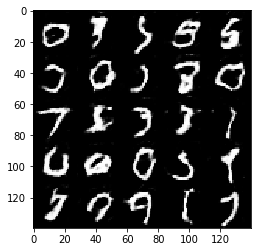

Epoch 2/2 Batch 6669/7500 Discriminator loss 0.8743 Generator loss 2.852
Epoch 2/2 Batch 6786/7500 Discriminator loss 0.965 Generator loss 5.3
Epoch 2/2 Batch 6903/7500 Discriminator loss 0.5338 Generator loss 4.198
Epoch 2/2 Batch 7020/7500 Discriminator loss 0.5422 Generator loss 3.3
Epoch 2/2 Batch 7137/7500 Discriminator loss 0.7151 Generator loss 3.862
Epoch 2/2 Batch 7254/7500 Discriminator loss 0.494 Generator loss 3.914
Epoch 2/2 Batch 7371/7500 Discriminator loss 0.7848 Generator loss 2.649
Epoch 2/2 Batch 7488/7500 Discriminator loss 0.5818 Generator loss 1.982


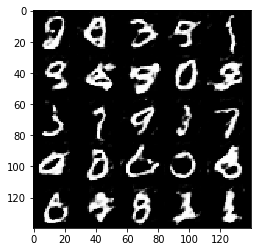

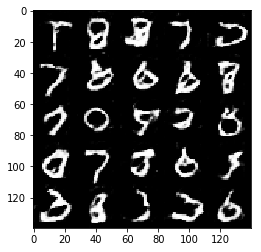

In [12]:
batch_size = 8
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch 395/25325 Discriminator loss 0.5392 Generator loss 3.147
Epoch 1/1 Batch 790/25325 Discriminator loss 0.6204 Generator loss 2.5
Epoch 1/1 Batch 1185/25325 Discriminator loss 1.591 Generator loss 1.711
Epoch 1/1 Batch 1580/25325 Discriminator loss 1.242 Generator loss 1.16
Epoch 1/1 Batch 1975/25325 Discriminator loss 0.664 Generator loss 2.318
Epoch 1/1 Batch 2370/25325 Discriminator loss 1.275 Generator loss 2.055
Epoch 1/1 Batch 2765/25325 Discriminator loss 1.476 Generator loss 1.258
Epoch 1/1 Batch 3160/25325 Discriminator loss 1.113 Generator loss 1.549


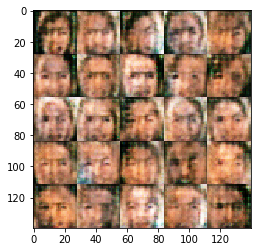

Epoch 1/1 Batch 3555/25325 Discriminator loss 1.306 Generator loss 0.6157
Epoch 1/1 Batch 3950/25325 Discriminator loss 1.056 Generator loss 0.9776
Epoch 1/1 Batch 4345/25325 Discriminator loss 1.167 Generator loss 1.043
Epoch 1/1 Batch 4740/25325 Discriminator loss 1.117 Generator loss 1.213
Epoch 1/1 Batch 5135/25325 Discriminator loss 1.419 Generator loss 0.7033
Epoch 1/1 Batch 5530/25325 Discriminator loss 1.318 Generator loss 1.602
Epoch 1/1 Batch 5925/25325 Discriminator loss 1.511 Generator loss 0.9857
Epoch 1/1 Batch 6320/25325 Discriminator loss 1.023 Generator loss 0.8883


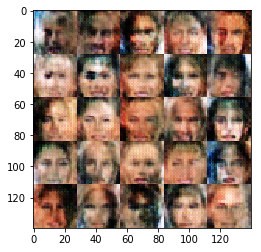

Epoch 1/1 Batch 6715/25325 Discriminator loss 1.587 Generator loss 0.9753
Epoch 1/1 Batch 7110/25325 Discriminator loss 1.051 Generator loss 1.056
Epoch 1/1 Batch 7505/25325 Discriminator loss 1.097 Generator loss 1.557
Epoch 1/1 Batch 7900/25325 Discriminator loss 1.114 Generator loss 1.321
Epoch 1/1 Batch 8295/25325 Discriminator loss 1.358 Generator loss 1.077
Epoch 1/1 Batch 8690/25325 Discriminator loss 1.223 Generator loss 1.215
Epoch 1/1 Batch 9085/25325 Discriminator loss 1.225 Generator loss 0.9577
Epoch 1/1 Batch 9480/25325 Discriminator loss 1.576 Generator loss 0.9178


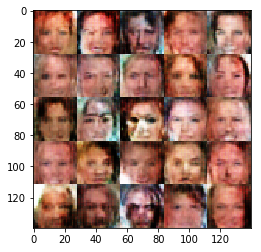

Epoch 1/1 Batch 9875/25325 Discriminator loss 1.01 Generator loss 1.249
Epoch 1/1 Batch 10270/25325 Discriminator loss 1.21 Generator loss 1.481
Epoch 1/1 Batch 10665/25325 Discriminator loss 1.277 Generator loss 1.53
Epoch 1/1 Batch 11060/25325 Discriminator loss 1.232 Generator loss 1.339
Epoch 1/1 Batch 11455/25325 Discriminator loss 1.136 Generator loss 1.021
Epoch 1/1 Batch 11850/25325 Discriminator loss 1.062 Generator loss 1.457
Epoch 1/1 Batch 12245/25325 Discriminator loss 1.093 Generator loss 1.214
Epoch 1/1 Batch 12640/25325 Discriminator loss 0.9115 Generator loss 1.462


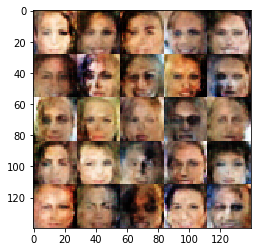

Epoch 1/1 Batch 13035/25325 Discriminator loss 1.138 Generator loss 0.9843
Epoch 1/1 Batch 13430/25325 Discriminator loss 1.19 Generator loss 1.68
Epoch 1/1 Batch 13825/25325 Discriminator loss 0.9105 Generator loss 0.8702
Epoch 1/1 Batch 14220/25325 Discriminator loss 0.883 Generator loss 1.44
Epoch 1/1 Batch 14615/25325 Discriminator loss 0.9948 Generator loss 1.029
Epoch 1/1 Batch 15010/25325 Discriminator loss 1.334 Generator loss 1.537
Epoch 1/1 Batch 15405/25325 Discriminator loss 0.988 Generator loss 1.135
Epoch 1/1 Batch 15800/25325 Discriminator loss 1.155 Generator loss 1.169


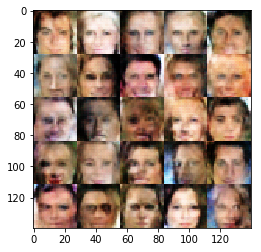

Epoch 1/1 Batch 16195/25325 Discriminator loss 1.066 Generator loss 1.469
Epoch 1/1 Batch 16590/25325 Discriminator loss 1.552 Generator loss 0.8532
Epoch 1/1 Batch 16985/25325 Discriminator loss 1.382 Generator loss 0.8985
Epoch 1/1 Batch 17380/25325 Discriminator loss 1.125 Generator loss 1.207
Epoch 1/1 Batch 17775/25325 Discriminator loss 0.9972 Generator loss 1.878
Epoch 1/1 Batch 18170/25325 Discriminator loss 1.295 Generator loss 1.049
Epoch 1/1 Batch 18565/25325 Discriminator loss 1.182 Generator loss 1.278
Epoch 1/1 Batch 18960/25325 Discriminator loss 1.134 Generator loss 1.33


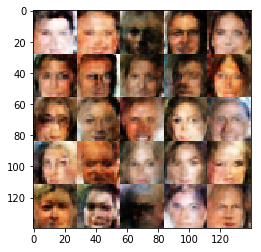

Epoch 1/1 Batch 19355/25325 Discriminator loss 1.506 Generator loss 1.635
Epoch 1/1 Batch 19750/25325 Discriminator loss 1.303 Generator loss 1.143
Epoch 1/1 Batch 20145/25325 Discriminator loss 1.343 Generator loss 1.401
Epoch 1/1 Batch 20540/25325 Discriminator loss 0.9942 Generator loss 1.527
Epoch 1/1 Batch 20935/25325 Discriminator loss 1.995 Generator loss 0.7927
Epoch 1/1 Batch 21330/25325 Discriminator loss 0.707 Generator loss 1.65
Epoch 1/1 Batch 21725/25325 Discriminator loss 1.295 Generator loss 0.7571
Epoch 1/1 Batch 22120/25325 Discriminator loss 1.235 Generator loss 1.301


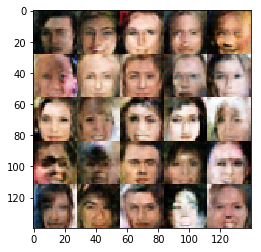

Epoch 1/1 Batch 22515/25325 Discriminator loss 0.9893 Generator loss 1.108
Epoch 1/1 Batch 22910/25325 Discriminator loss 1.067 Generator loss 1.529
Epoch 1/1 Batch 23305/25325 Discriminator loss 1.373 Generator loss 0.9278
Epoch 1/1 Batch 23700/25325 Discriminator loss 1.011 Generator loss 1.251
Epoch 1/1 Batch 24095/25325 Discriminator loss 0.9096 Generator loss 1.398
Epoch 1/1 Batch 24490/25325 Discriminator loss 0.8734 Generator loss 1.414
Epoch 1/1 Batch 24885/25325 Discriminator loss 1.568 Generator loss 1.435
Epoch 1/1 Batch 25280/25325 Discriminator loss 0.7492 Generator loss 1.228


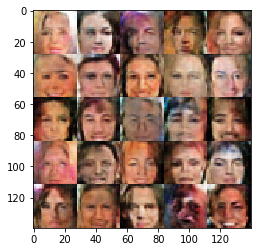

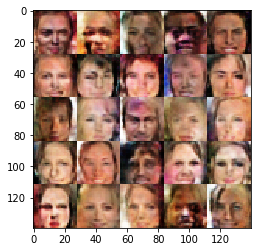

In [13]:
batch_size = 8
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.